In [1027]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon 
from pylab import figure, show, legend, ylabel
from math import e, pi, isinf

In [1545]:
class BuckleyLev():
    
    def __init__(self):
        self.params = {
            #non wetting phase viscosity
            "viscosity_o": 1.e-3,
            #wetting phase viscosity
            "viscosity_w": 0.5e-3,
            #initial water sat
            "initial_sw":0.4,
            #residual water saturation, Swirr
            "residual_w":0.1,
            #residual oil saturation, Sor
            "residual_o":0.1,
            #connate water saturation 
            #water rel perm at water curve end point
            "krwe":1,
            #oil rel perm at oil curve end point
            "kroe": 0.9,
            #dimless velocity results
            'vd_array':[],
            #porosity
            'poro':0.24,
            #water injection rate units m3/hr
            "inject_rate":200,
            #cross sectional area units m2
            "x-area":30
        }

In [1546]:
def k_rw(self,sw):
    #water relative perm calculation for a given water saturation 
    p = 11.174
    return ((self.params['krwe']))*sw**p

BuckleyLev.k_rw = k_rw

In [1547]:
def k_rn(self,sw):
    #oil relative perm calculation for a given water saturation 
    q = 3.326
    return ((1.-self.params['kroe']*sw)**q)

BuckleyLev.k_rn = k_rn

In [1548]:
def fractional_flow(self,sw):
    #returns the fractional flow
    
    return 1./(1.+((self.k_rn(sw)/self.k_rw(sw))*(self.params["viscosity_w"]/self.params["viscosity_o"])))

BuckleyLev.fractional_flow = fractional_flow

In [1549]:
def plot_fractional_flow(self):
    #plot the sw vs fractional flow
    
    #x = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]+1e-3),100)
    x = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]),100)
    y = [self.fractional_flow(i) for i in x ]
    
    plt.plot(x,y)
    
    #sw_at_front = self.sw_at_shock_front()
    #plt.plot([sw_at_front],[self.fractional_flow(sw_at_front)],'ro')
    
    plt.title('Fractional flow as a function of water saturation')
    plt.xlabel('Sw')
    plt.ylabel('Fractional flow')
    plt.ylim([0,1.1])
    plt.xlim([0,1])
    
    #add limiting fractional flow lines
    plt.hlines(y[len(y)-1],0,1,linestyles='dashed',lw=2, colors='0.4')
    plt.annotate('fw max: %.4f' % y[len(y)-1],xy=(0.08,0.95))
    
    
    #plt.show()
    #print(y[len(y)-1])
    
BuckleyLev.plot_fractional_flow = plot_fractional_flow

In [1550]:
def fractional_flow_deriv(self,sw):
    #calculate derivative of fractional flow - dFw/dSw - Vsh
    
    f_deriv = (self.fractional_flow(sw+0.0001) - self.fractional_flow(sw))/0.0001
    
    return f_deriv

BuckleyLev.fractional_flow_deriv = fractional_flow_deriv

In [1551]:
def plot_fractional_flow_deriv(self):
    #plot the derivative dFw/dSw - Vsh vs Sw
    x = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]),100)
    y = [self.fractional_flow_deriv(i) for i in x ]
    
    plt.plot(x,y)
    plt.title('Derivative of fractional flow curve')
    plt.ylabel('dfw/dSw')
    plt.xlabel('Sw')
    plt.show()
    
BuckleyLev.plot_fractional_flow_deriv=plot_fractional_flow_deriv

In [1552]:
def frac_deriv_combo(self):
    x = np.linspace(self.params["residual_w"]+1e-3,((1-self.params["residual_o"])),100)
    # is the fractional flow curve
    y = [self.fractional_flow(i) for i in x ]
    
    #y2 is the derivative
    y2 = [self.fractional_flow_deriv(i) for i in x ]
 
    fig1 = figure()
    
    ax1 = fig1.add_subplot(111)
    line1 = ax1.plot(x,y,lw=2)
    ylabel("Fractional flow")
    ax1.set_ylim([0,1.2])
  
    
    ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
    line2 = ax2.plot(x,y2,'-r',lw=2)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ylabel("Derivative dfw/dsw")
    ax2.set_xlim([0.4,1])
    
    plt.title('Fractional flow as a function of water saturation')
    
    plt.xlabel('Sw')
    
    ax1.hlines(y[len(y)-1],0,1,linestyles='dashed',lw=2, colors='0.4')
    ax1.annotate('fw max: %.4f' % y[len(y)-1],xy=(0.85,1.02))
    
    
    ax1.spines['left'].set_color('blue')
    ax1.tick_params(axis='y', colors='blue')
    
    ax1.spines['right'].set_color('red')
    ax2.tick_params(axis='y', colors='red')
    

    show()
    
BuckleyLev.frac_deriv_combo = frac_deriv_combo

In [1553]:
#generate xt curve for a given time step, if no time step, timwe =1 
def xt(self,time=1):
    
    flux = ((self.params['inject_rate'])/(60.0*60.0))/self.params['x-area']
    td = (flux*time)/(self.params['x-area']*self.params['poro'])
    
    y = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]),50)
    x = [(self.fractional_flow_deriv(i))*td for i in y]
    
    return(x,y)

BuckleyLev.xt = xt
    


In [1554]:
def shock_sat(self):
    
    #create dx window of increasing size for calculating welge

    x = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]),100)
    y = [self.fractional_flow(i) for i in x ]
  
    maximum, sw_shock = 0,0
    grads = []
    
    for index,item in enumerate(y):
        
        grad = (item - (y[0]+0.00001))/(x[index]-(x[0]+0.001)) 
        
        
        if grad>maximum:
            #plt.plot([self.params["residual_w"]+1e-3,x[index]],[0,item],'o-')
            sw_shock = x[index]
            maximum = grad
    
    #plt.show()
    #print(sw_shock)
    return(sw_shock)
 

BuckleyLev.shock_sat = shock_sat
    

In [1555]:
a = BuckleyLev()

In [1556]:
shk = a.shock_sat()

In [1557]:
a.plot_fractional_flow()

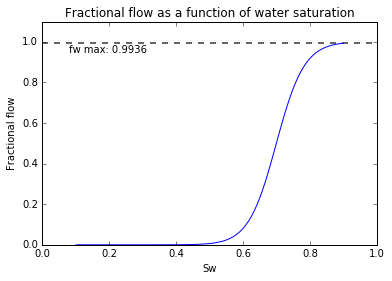

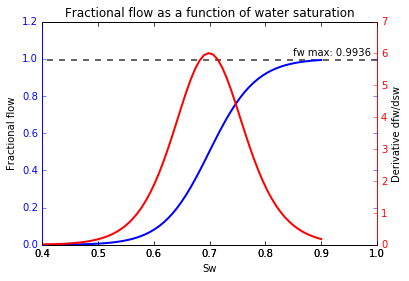

In [1558]:

a.frac_deriv_combo()
plt.show()

In [1559]:
def plot_xd(self,times=[1]):
    
    colors = {0:'r',1:'b',2:'c',3:'g'}
    max_val = 0
    
    for index,time in enumerate(times):
        if (max(a.xt(time)[0]) > max_val):
            max_val = max(a.xt(time)[0])
            
        plt.plot(a.xt(time)[0],a.xt(time)[1],colors[index],lw=2)

    plt.hlines(self.shock_sat(),0,7,linestyles='dashed',lw=2, colors='0.4')
    
    plt.annotate('Sw shock: %.2f' % self.shock_sat(),xy=(max_val-1.3,self.shock_sat()+0.012))
    plt.ylim([0,1])
    plt.show()
    
BuckleyLev.plot_xd = plot_xd

In [1560]:
def slice_rarefaction(self,time):
    
    #generate the xt data 
    xt, sw = self.xt(time)
    index = 0

    #find out where the shock saturation is
    shock_sat = self.shock_sat()
    
    #now trim xt and sw arrays 
    for index, item in enumerate(sw):
        if item >= shock_sat:
            lim = index
            break
            
    sw_trim = (sw[lim:])
    xt_trim = (xt[lim:])
  
    return(sw_trim,xt_trim)
    
    
    
BuckleyLev.slice_rarefaction = slice_rarefaction

    

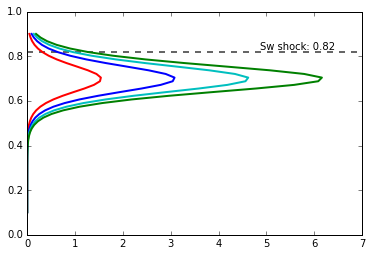

In [1561]:
a = BuckleyLev()
a.plot_xd([1000,2000,3000,4000])

In [1562]:
a.slice_rarefaction(1000)

(array([ 0.83477551,  0.85108163,  0.86738776,  0.88369388,  0.9       ]),
 [0.2233635765433416,
  0.15356318003323696,
  0.10420268985441156,
  0.069858357148850872,
  0.046269935048767051])

In [1563]:
def plot_sat_front(self,times=[1]):
    colors = {0:'r',1:'b',2:'c',3:'g'}
       
    for index, time in enumerate(times):
        
        y = sorted((self.slice_rarefaction(time)[0]))
        x = sorted((self.slice_rarefaction(time)[1]),reverse=True)
        plt.plot(x,y,colors[index],lw=2)

        if (x[len(x)-1]>0.001):
            #plt.plot([0,x[len(x)-1]],[1,1],'b',lw=2)
            plt.hlines(1-self.params["residual_o"],0,x[len(x)-1],colors[index],lw=2)
            plt.plot(x[len(x)-1],y[len(y)-1],colors[index]+'o')


        plt.vlines(x[0],y[0],self.params["initial_sw"],colors[index],lw=2)
        plt.hlines(self.params["initial_sw"],x[0],x[0]+1,colors[index],lw=2)

        #highlight vshock point
        plt.plot(x[0],y[0],colors[index]+'o') 

    plt.ylim([0,1])
    plt.xlim([0,x[0]+1])
    
    plt.show()
BuckleyLev.plot_sat_front = plot_sat_front

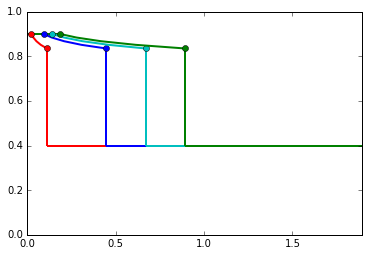

In [1565]:
a = BuckleyLev()
a.plot_sat_front([500,2000,3000,4000])

In [1486]:
colors = {1:'r',2:'b'}
colors[1]+'o'

'ro'